In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import log_loss
from sklearn.decomposition import PCA, NMF, FastICA
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Setting up the possible latent dimensions
# A total of 26 latent dimensions are taken under consideration

k_list = []
k_list.extend(list(range(2, 10)))
k_list.extend(list(range(10, 20, 2)))
k_list.extend(list(range(20, 50, 5)))
k_list.extend(list(range(50, 61, 10)))
k_list.append(78)
k_list.extend(list(range(80, 100, 10)))
k_list.extend(list(range(100, 151, 25)))

print("Latent dimensions:")
print(k_list)

Latent dimensions:
[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 60, 78, 80, 90, 100, 125, 150]


In [3]:
# Read the data. The df_new file has additional information about each sample
# such as the following:
#   - PCOS/Control
#   - Cell type
#   - Dataset they belong to

df = pd.read_csv("../datasets/common_normalized.csv", index_col=0)
df_new = pd.read_csv("../datasets/control_pcos_celltype_mapping.csv")
display(df_new)

,sample_id,PCOS/Control,cell_type,dataset
0,GSM1174425,PCOS,endothelial,GDS4987
1,GSM1174429,PCOS,endothelial,GDS4987
2,GSM1174436,PCOS,endothelial,GDS4987
3,GSM1174427,PCOS,epithelial,GDS4987
4,GSM1174430,PCOS,epithelial,GDS4987
...,...,...,...,...
170,GSM27534,control,theca,GDS1050
171,GSM27543,valproic,theca,GDS1050
172,GSM27546,valproic,theca,GDS1050
173,GSM27548,valproic,theca,GDS1050


In [4]:
# Rearrange the rows in df_new to ensure that the 
position = []
values = list(df_new["sample_id"])
for i,j in enumerate(df["sample_id"]):
    position.append(values.index(j))

df_new = df_new.loc[position]
df_new = df_new.reset_index()
df_new = df_new.drop("index", axis=1)

# Merge the two dataframes together
result = pd.merge(df, df_new[df_new.columns[:-1]], how='inner', on='sample_id')
display(result)

,sample_id,27,36,59,87,94,105,153,164,159,...,100132341,100287932_100652748,387893,388336,259266,317762,261726,PCOS,PCOS/Control,cell_type
0,GSM27536,0.693258,0.125461,0.336077,0.044463,0.267819,0.467742,0.490196,0.370576,0.008907,...,0.412466,0.601428,0.000000,0.312354,0.198387,0.770810,0.120213,1,PCOS,theca
1,GSM27537,0.214607,0.487085,0.589704,0.104294,0.000000,0.106452,0.000000,0.476058,0.631829,...,0.325390,0.850926,0.356499,0.173660,0.430645,0.000000,1.000000,1,PCOS,theca
2,GSM27538,0.241573,0.446494,0.548203,0.247916,0.033477,1.000000,0.137255,0.529493,0.457245,...,0.252062,1.000000,0.371943,0.097902,0.517742,0.676169,0.673404,1,PCOS,theca
3,GSM27540,0.000000,0.173432,0.000000,0.139978,0.242981,0.000000,0.117647,0.761277,0.350356,...,0.195234,0.791564,0.444015,0.132867,0.156452,0.729761,0.730851,1,PCOS,theca
4,GSM27541,0.723596,0.845018,0.373149,0.446988,0.768898,0.212903,0.352941,0.722415,1.000000,...,0.000000,0.267351,0.549550,0.343823,1.000000,0.329532,0.000000,1,PCOS,theca
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,GSM1174420,0.581038,0.637359,1.000000,1.000000,0.185537,0.404005,0.550455,0.423211,0.683348,...,0.250726,0.765354,0.759678,0.277592,0.570973,0.200546,0.557889,-1,control,mesenchymal
171,GSM1174410,0.266673,0.783178,0.487781,0.475529,0.342318,0.581647,0.313639,0.341682,0.616150,...,0.547353,0.633198,0.386967,0.683394,0.712426,0.648506,0.671575,-1,control,stromal
172,GSM1174411,0.132671,0.812518,0.490907,0.276122,0.299019,0.514624,0.455273,0.348759,0.707459,...,0.375745,0.966289,0.086710,0.436739,0.775867,0.504792,1.000000,-1,control,stromal
173,GSM1174415,0.219215,0.935999,0.589718,0.443145,0.302450,0.435289,0.000000,0.693894,0.578225,...,0.283685,0.956116,0.228903,0.929545,0.710650,0.238808,0.872641,-1,control,stromal


In [5]:
X = df[df.columns[1:-1]].to_numpy()
X.shape

(175, 1667)

In [6]:
def get_cost_reconstruction(model, k_list=k_list):
    bce_loss = []
    l2_error = []
    output = []
    
    print("Calculating Reconstruction Error for:", model.upper())
    time.sleep(1)
    
    if model == "pca":
        for k in tqdm(k_list):
            model = PCA(n_components=k, random_state=4)
            model.fit(X)
            reduced = model.transform(X)
            reconstructed = model.inverse_transform(reduced)
            bce_loss.append(log_loss(X.reshape(-1,).astype(int), reconstructed.reshape(-1,)))
            l2_error.append(np.linalg.norm(X-reconstructed))
            output.append(reconstructed)

    if model == "ica":
        for k in tqdm(k_list):
            model = FastICA(n_components=k, random_state=4, max_iter=400)
            model.fit(X)
            reduced = model.transform(X)
            reconstructed = model.inverse_transform(reduced)
            bce_loss.append(log_loss(X.reshape(-1,).astype(int), reconstructed.reshape(-1,)))
            l2_error.append(np.linalg.norm(X-reconstructed))
            output.append(reconstructed)

    if model == "nmf":
        for k in tqdm(k_list):
            model = NMF(n_components=k, random_state=4, max_iter=400)
            model.fit(X)
            reduced = model.transform(X)
            reconstructed = model.inverse_transform(reduced)
            bce_loss.append(log_loss(X.reshape(-1,).astype(int), reconstructed.reshape(-1,)))
            l2_error.append(np.linalg.norm(X-reconstructed))
            output.append(reconstructed)
    
    return bce_loss, l2_error, output

In [7]:
model_list = ["pca", "ica", "nmf"]
bce_loss = []
l2_error = []
reconstruction_list = []

for model in model_list:
    bce, l2, output = get_cost_reconstruction(model)
    bce_loss.append(bce)
    l2_error.append(l2)
    reconstruction_list.append(output)

Calculating Reconstruction Error for: PCA


100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


Calculating Reconstruction Error for: ICA


100%|██████████| 27/27 [00:14<00:00,  1.81it/s]


Calculating Reconstruction Error for: NMF


100%|██████████| 27/27 [03:40<00:00,  8.15s/it]


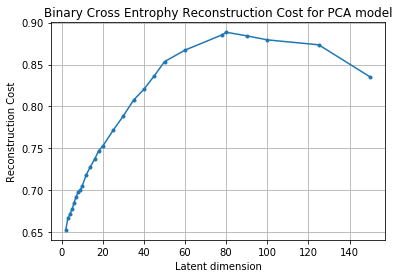

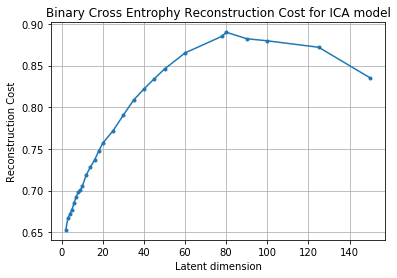

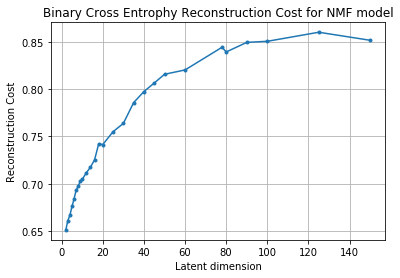

In [8]:
for i,j in zip(model_list, bce_loss):
    plt.title("Binary Cross Entrophy Reconstruction Cost for " + i.upper() + " model")
    plt.xlabel("Latent dimension")
    plt.ylabel("Reconstruction Cost")
    plt.plot(k_list, j, '.-')
    plt.grid()
    plt.show()

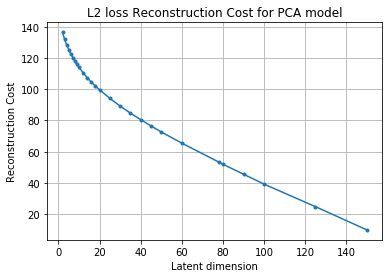

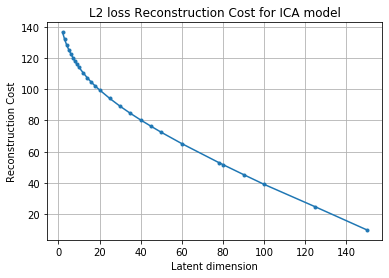

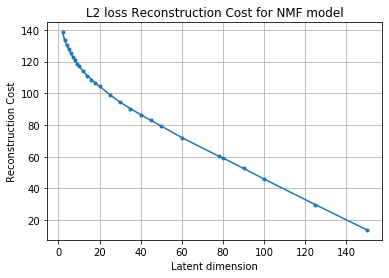

In [9]:
for i,j in zip(model_list, l2_error):
    plt.title("L2 loss Reconstruction Cost for " + i.upper() + " model")
    plt.xlabel("Latent dimension")
    plt.ylabel("Reconstruction Cost")
    plt.plot(k_list, j, '.-')
    plt.grid()
    plt.show()

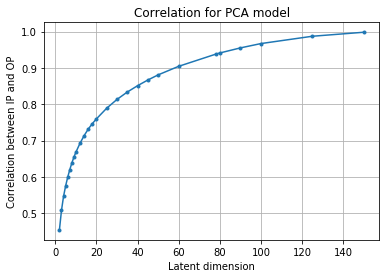

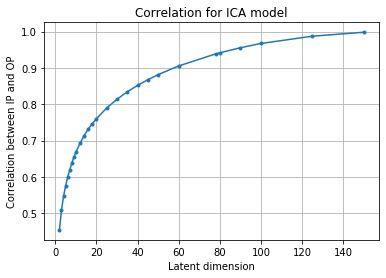

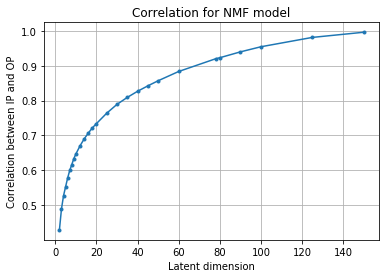

In [10]:
for i,model_wise in zip(model_list, reconstruction_list):
    correlation_list = []
    for j in model_wise:
        corr = np.corrcoef(X.reshape(-1,), j.reshape(-1,))[0,1]
        correlation_list.append(corr)
    
    plt.title("Correlation for " + i.upper() + " model")
    plt.xlabel("Latent dimension")
    plt.ylabel("Correlation between IP and OP")
    plt.plot(k_list, correlation_list, '.-')
    plt.grid()
    plt.show()